In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import sqlite3
import re
import matplotlib.pyplot as plt

In [ ]:
dbfile = '13.7 chinook.db'
conn = sqlite3.connect(dbfile)
cursor = conn.cursor()

cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(f"Table Name : {cursor.fetchall()}")

Table Name : [('album',), ('artist',), ('customer',), ('employee',), ('genre',), ('invoice',), ('invoice_line',), ('media_type',), ('playlist',), ('playlist_track',), ('track',)]


In [ ]:
result = [a for a in cursor.execute("SELECT COUNT(*) as total, SUM(CASE WHEN Composer is NULL THEN 1 ELSE 0 END) as nullable FROM track")]
print(result)

[(3503, 978)]


In [ ]:
query = """
SELECT
    invoice.invoice_id,
    invoice.invoice_date,
    invoice.customer_id,
    invoice_line.track_id,
    CASE
        WHEN genre.name IN ('Rock', 'Alternative & Punk', 'Metal', 'Alternative', 'Heavy Metal') THEN 'rock'
        ELSE 'others'
    END AS genre_category,
    invoice_line.unit_price AS track_price
FROM invoice
JOIN invoice_line ON invoice.invoice_id = invoice_line.invoice_id
JOIN track ON invoice_line.track_id = track.track_id
JOIN genre ON track.genre_id = genre.genre_id
JOIN media_type ON track.media_type_id = media_type.media_type_id
WHERE invoice.invoice_date LIKE '2020%' AND media_type.name = 'audio';
"""

df = pd.read_sql_query(query, conn)

missing_values = df.isnull().sum()

duplicate_rows = df.duplicated().sum()


missing_values, duplicate_rows


(invoice_id        0.0
 invoice_date      0.0
 customer_id       0.0
 track_id          0.0
 genre_category    0.0
 track_price       0.0
 dtype: float64,
 0)

In [ ]:
query = """
SELECT
    invoice_id,
    substr(invoice_date, 1, 7) || '-01' AS first_day_of_month
FROM invoice;
"""

result = pd.read_sql_query(query, conn)

result.head()

,invoice_id,first_day_of_month
0,1,2017-01-01
1,2,2017-01-01
2,3,2017-01-01
3,4,2017-01-01
4,5,2017-01-01


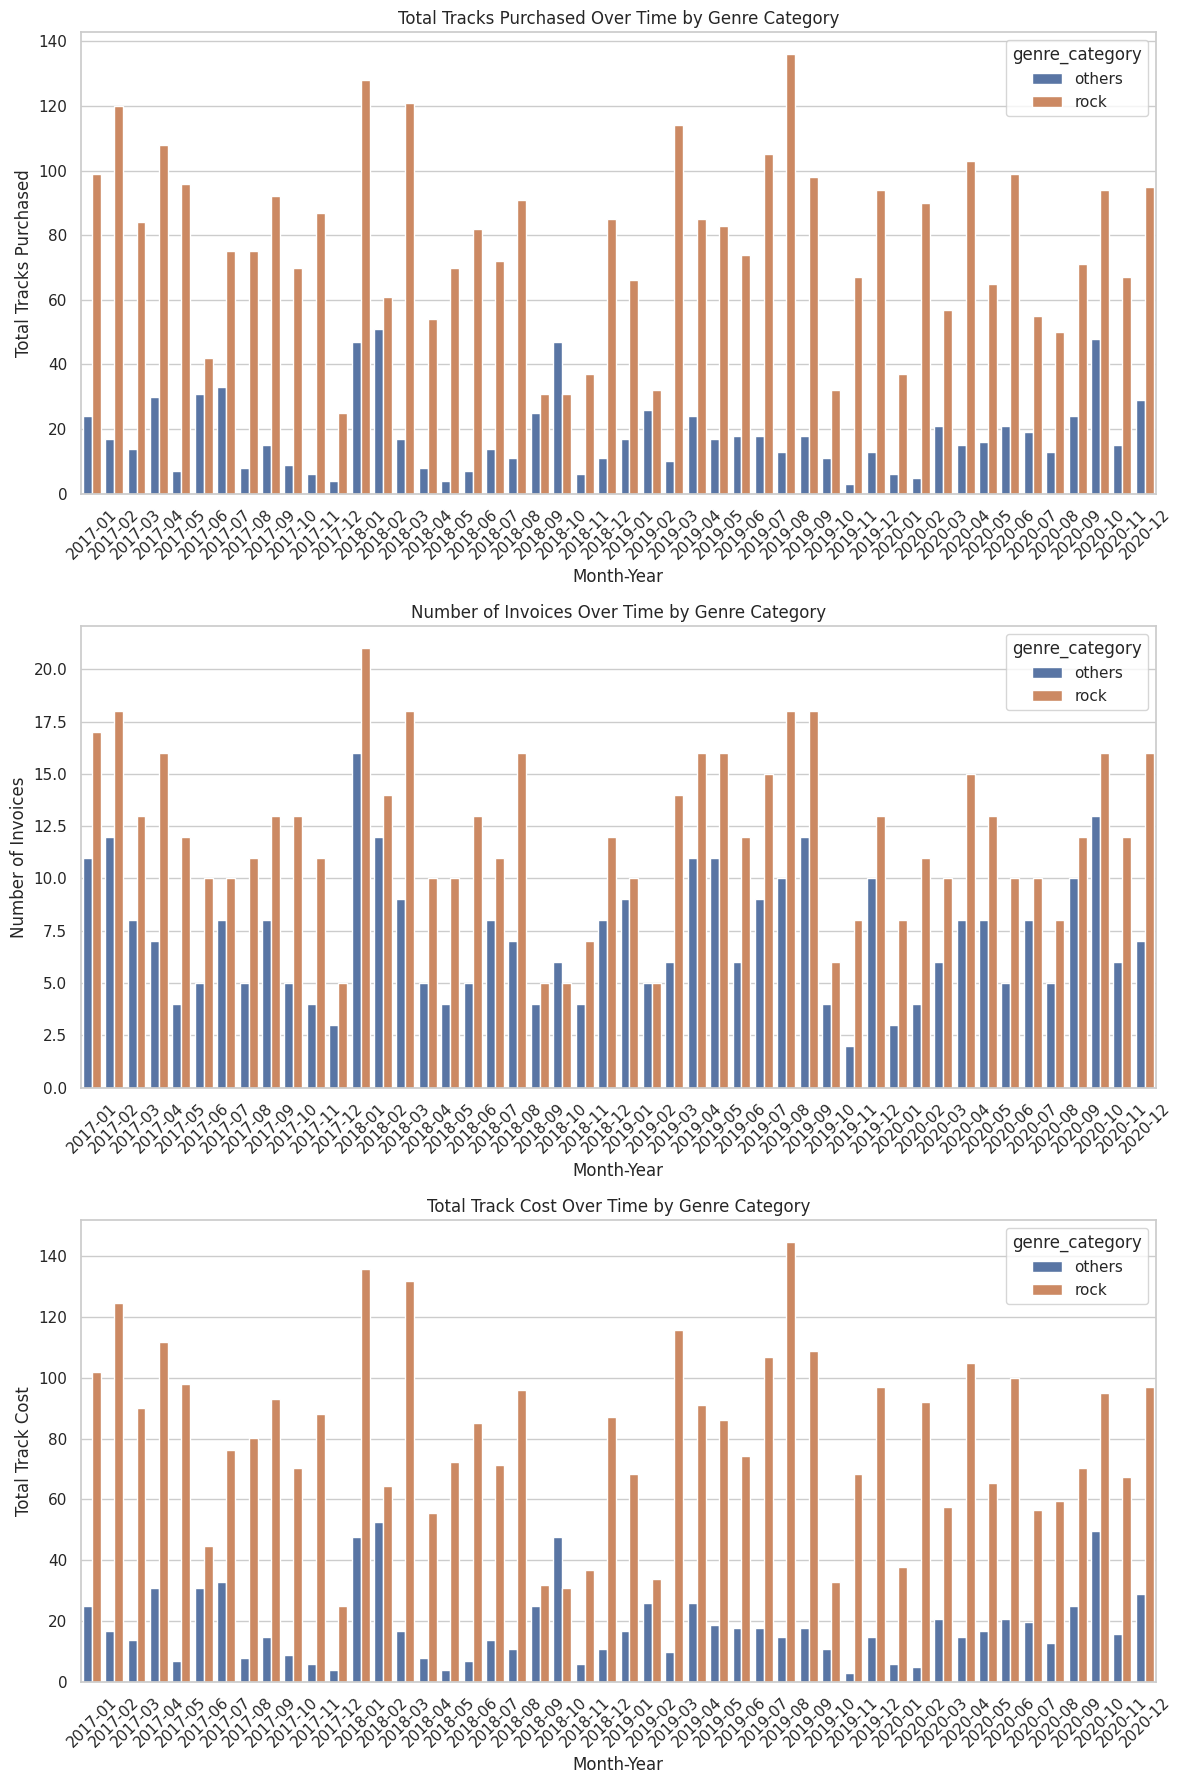

In [ ]:
query = """
SELECT
    strftime('%Y-%m', invoice.invoice_date) AS month_year,
    CASE
        WHEN genre.name IN ('Rock', 'Alternative & Punk', 'Metal', 'Alternative', 'Heavy Metal') THEN 'rock'
        ELSE 'others'
    END AS genre_category,
    COUNT(DISTINCT invoice_line.track_id) AS total_tracks_purchased,
    COUNT(DISTINCT invoice.invoice_id) AS number_of_invoices,
    COUNT(DISTINCT invoice.customer_id) AS number_of_customers,
    SUM(invoice_line.unit_price) AS total_track_cost
FROM invoice
JOIN invoice_line ON invoice.invoice_id = invoice_line.invoice_id
JOIN track ON invoice_line.track_id = track.track_id
JOIN genre ON track.genre_id = genre.genre_id
GROUP BY month_year, genre_category;
"""

result = pd.read_sql_query(query, conn)

sns.set(style="whitegrid")

fig, axes = plt.subplots(3, 1, figsize=(12, 18))

plot1 = sns.barplot(data=result, x="month_year", y="total_tracks_purchased", hue="genre_category", ax=axes[0])
plot1.set_title('Total Tracks Purchased Over Time by Genre Category')
plot1.set_xlabel('Month-Year')
plot1.set_ylabel('Total Tracks Purchased')
plot1.set_xticklabels(plot1.get_xticklabels(), rotation=45)

plot2 = sns.barplot(data=result, x="month_year", y="number_of_invoices", hue="genre_category", ax=axes[1])
plot2.set_title('Number of Invoices Over Time by Genre Category')
plot2.set_xlabel('Month-Year')
plot2.set_ylabel('Number of Invoices')
plot2.set_xticklabels(plot2.get_xticklabels(), rotation=45)

plot3 = sns.barplot(data=result, x="month_year", y="total_track_cost", hue="genre_category", ax=axes[2])
plot3.set_title('Total Track Cost Over Time by Genre Category')
plot3.set_xlabel('Month-Year')
plot3.set_ylabel('Total Track Cost')
plot3.set_xticklabels(plot3.get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()

Опираясь на данные, которые мы получили, можно увидеть, музыка жанра "Rock", ежемесячно доминирует остальные жанры по всем показателям  